In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Introduction

In this exercise, you'll use 2015 data from [LendingClub](https://www.lendingclub.com/legal/prospectus?) to predict the current status of a loan from other information about the loan itself. You can access the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1).

In [2]:
start = time.time()

# Replace the path below with the correct path for your data
y2015 = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

print(f'Total time to read in raw data: {round(time.time() - start, 2)} seconds.')

# Note the warning about dtypes

C:\ProgramData\Anaconda3\envs\thinkful\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total time to read in raw data: 94.37 seconds.


In [3]:
# Number of rows and columns
y2015.shape

(421097, 111)

In [4]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [5]:
# Distribution of response values (note that this is a multiclass problem, not binary)
y2015['loan_status'].value_counts()

Current               287414
Fully Paid             87989
Charged Off            29178
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

## A first-pass model

As you can see from the basic exploratory analysis above, this dataset contains a large number of features. Although the end goal is usually a model that balances performance and parsimony (a minimal number of features), a common approach when building a first-pass model is to include all available features. Although this will inevitably result in some degree of overfitting, random forests are relatively good at reducing the impact of unimportant features on prediction accuracy.

Because the scikit-learn implementation of random forest requires all features in the model to be numeric, you will need to encode the categorical features numerically.  One-hot encoding is a simple and popular technique for converting categorical features to numeric, and the `get_dummies()` method from pandas provides an easy way to accomplish this task. The `get_dummies()` method takes each column of type `object` in the original DataFrame and replaces it with `N` separate numeric columns, `N` being the total number of categories in that column. Each of the new columns will be binary (with `1` and `0` values) and correspond to one of the categories in the original categorical variable.

To explore this, consider the example below.

In [6]:
y2015['term'].unique()

array([' 60 months', ' 36 months', nan], dtype=object)

The `term` column takes on two non-numeric values: `60 months` and `36 months`. (You can disregard the `nan` for this example.) Below, output the first five values in the dataset under the `term` column. This allows you to relate the output of the `get_dummies()` function to the original values in the column.

In [7]:
y2015['term'].head()

0     60 months
1     36 months
2     36 months
3     36 months
4     36 months
Name: term, dtype: object

After running the `get_dummies()` function on the `term` column, the output is two new binary columns: `36 months` and `60 months`. If the original value of a record in `term` was `36 months`, then its value in the corresponding binary column will be `1`, and its value in `60 months` will be `0`.

In [8]:
pd.get_dummies(y2015['term'].head())

,36 months,60 months
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


What would happen if you converted all of the categorical features to numeric using one-hot encoding and performed 10-fold cross-validation using a random forest classifier on the resulting dataset?

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

run_cell = False  # You don't actually want to run this cell; it's just for demonstration purposes

if run_cell:
    rfc = ensemble.RandomForestClassifier()
    X = y2015.drop('loan_status', 1)
    Y = y2015['loan_status']
    X = pd.get_dummies(X)

    cross_val_score(rfc, X, Y, cv=5)

Running the previous cell will almost certainly result in the Notebook crashing. (No need to run the cell to verify!) Below, you'll investigate why this is the case.


## Data cleaning

The `get_dummies()` method can be very memory intensive, especially when dealing with *high-cardinality* categorical features, which are any features that have a large number of categories or distinct values. This can be particularly problematic when a continuous numeric column is accidentally read in as a categorical variable—chances are, each row has a unique value, so attempting to one-hot encode such a variable would amount to adding more than 400,000 columns to the dataset!

Below, look at all your categorical variables and see how many unique categories are present for each feature. Additionally, note that the `member_id` column was read in as an integer; however, it is best practice to convert identifier columns to categorical, because the ordering imposed by the numbers has little or no meaning in this modeling context.

In [10]:
# Convert `member_id` to string; it generally isn't appropriate to represent identifier fields as numbers
y2015['member_id'] = y2015['member_id'].astype(str)

# Identify categorical columns
categorical = y2015.select_dtypes(include=['object'])
categorical_dict = {}

# Create dictionary of categorical columns and the number of unique categories for each one
for i in categorical:
    column = categorical[i]
    num_unique = column.nunique()
    categorical_dict[i] = num_unique

for key, value in categorical_dict.items():
    print(f'{key}: {value}')

id: 421097
member_id: 421096
term: 2
int_rate: 110
grade: 7
sub_grade: 35
emp_title: 120812
emp_length: 11
home_ownership: 4
verification_status: 3
issue_d: 12
loan_status: 7
pymnt_plan: 1
url: 421095
desc: 34
purpose: 14
title: 27
zip_code: 914
addr_state: 49
earliest_cr_line: 668
revol_util: 1211
initial_list_status: 2
last_pymnt_d: 25
next_pymnt_d: 4
last_credit_pull_d: 26
application_type: 2
verification_status_joint: 3


As you can see, some of these features have hundreds or even thousands of distinct values. In the most extreme cases—`id`, `member_id`, and `url`—all or nearly all rows have a unique value, suggesting that the column is effectively a unique identifier for the loan. 

To clean the data, complete the following steps:

- Drop the columns with over 30 unique values.
- Convert to numeric where it makes sense. For example, `int_rate` represents numeric information about the interest rate, but it was read in as a string because of the `%` symbol at the end of each value. 
- Remove the date columns (column names ending in `_d`), because dates aren't suitable inputs to predictive models on their own. It is possible to generate numeric features from these dates; feel free to do so on your own, if inclined.

In [11]:
# Created a cleaned data DataFrame, which is initially a copy of the raw data
y2015_cleaned = y2015.copy()

# Convert `int_rate` to numeric
y2015_cleaned['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop high-cardinality categorical features
drop_cols = [col for col, value in categorical_dict.items() if value >= 30 and col != 'int_rate']
print(f'High-cardinality columns to drop: {drop_cols}\n')
print(y2015_cleaned.columns)
y2015_cleaned.drop(drop_cols, 1, inplace=True)

# Drop date columns
date_cols = list(y2015_cleaned.filter(regex='_d$').columns)
y2015_cleaned.drop(date_cols, 1, inplace=True)

print(y2015_cleaned.shape)

High-cardinality columns to drop: ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util']

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)
(421097, 97)


Additionally, note that there are two summary rows at the end of the dataset that don't contain actual loan information:

In [12]:
y2015_cleaned.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,RENT,35000.0,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,RENT,64400.0,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,RENT,100000.0,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After removing these two rows, one last data-cleaning step is to remove all columns with missing values. Normally, it would be better to avoid taking such a drastic step; instead, it would make sense to pursue alternatives, such as imputation, dropping observations with missing values, and so forth. But in this case, you will still have enough features left for the first-pass model to be useful.

In [13]:
# Remove two summary rows (that don't actually contain data) at the end
y2015_cleaned = y2015_cleaned[:-2]

# Drop columns with missing values
y2015_cleaned.dropna(axis=1, inplace=True)

print(y2015_cleaned.shape)

(421095, 65)


Try one-hot encoding the categorical variables again:

In [14]:
pd.get_dummies(y2015_cleaned)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,0.0,11.0,...,0,0,0,0,0,0,0,1,1,0
1,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,0.0,7.0,...,0,0,0,0,0,0,0,1,1,0
2,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,1.0,9.0,...,0,0,0,0,0,0,0,1,1,0
3,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,0.0,16.0,...,0,0,0,0,0,0,0,1,1,0
4,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,4.0,18.0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,10000.0,10000.0,10000.0,11.99,332.10,31000.0,28.69,0.0,0.0,9.0,...,0,0,0,0,0,0,1,0,1,0
421091,24000.0,24000.0,24000.0,11.99,797.03,79000.0,3.90,0.0,1.0,5.0,...,0,0,0,0,0,0,1,0,1,0
421092,13000.0,13000.0,13000.0,15.99,316.07,35000.0,30.90,0.0,0.0,9.0,...,0,0,0,0,0,0,0,1,1,0
421093,12000.0,12000.0,12000.0,19.99,317.86,64400.0,27.19,1.0,2.0,17.0,...,0,0,0,0,0,0,0,1,1,0


You can see that the number of additional columns (33) generated by one-hot encoding the categorical features in the dataset is much more reasonable after removing the categorical features with high cardinality, dates, or missing values.

## Second attempt at a first-pass random forest model

Now, try evaluating the performance of the first-pass, all-features random forest model using 10-fold CV again, after performing all of the necessary data-cleaning steps.

In [15]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time

start = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
X = y2015_cleaned.drop('loan_status', 1)
Y = y2015_cleaned['loan_status']
X = pd.get_dummies(X)

print(f'{cross_val_score(rfc, X, Y, cv=10)}\n')

print(f'Cross-validation time elapsed: {round(time.time() - start, 2)} seconds.')

[0.95447637 0.96468772 0.96250297 0.96074567 0.96072192 0.96069724
 0.96041226 0.96043601 0.96041226 0.96045976]

Cross-validation time elapsed: 66.49 seconds.


As you can see, the estimated out-of-sample accuracy is about 96%. (Your runtime may be different, depending on the specs of your machine; at worst, it shouldn't take more than five minutes).

**Note:** A more efficient way of estimating the out-of-sample accuracy that is unique to bootstrap-based approaches such as random forests is out-of-bag (OOB) error. When generating bootstrapped training samples for each tree, some proportion of the full set of training observations are left out; these "out-of-bag" samples can be used to estimate generalization error without needing to retrain the model several times, as is required for cross-validation. For more details, refer to the scikit-learn `RandomForestClassifier` documentation on the `oob_score` parameter and `oob_score_` attribute.

Although this model deals with the large number of features well, it is likely that many of the variables in the model contribute little or nothing to the final prediction, resulting in an unnecessarily complex model that may show performance degradation in the future. You can get an initial sense of how many of the features are unimportant by examining the feature importances calculated by scikit-learn during the model-building process:

<AxesSubplot:>

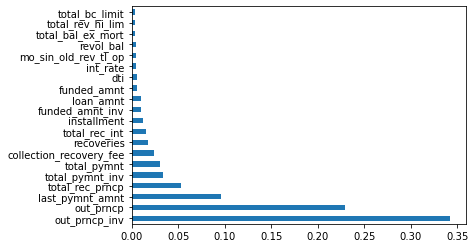

In [16]:
import matplotlib.pyplot as plt

rfc.fit(X, Y)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

As you can see, only a handful of the original ~100 features have a significant impact on the out-of-sample predictions. Furthermore, the importance of the features drops off rapidly after the top 10-15 features. Further iteration on this model would include removing the unnecessary features, deriving new features from the ones provided in the source data, and parameter tuning (although another strength of random forests is the relatively small number of parameters to tune).